## Setting up:

In [ ]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import warnings
import massbalancemachine as mbm
import pyproj
import seaborn as sns
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
from oggm import utils
from tqdm import tqdm
from cmcrameri import cm
from scripts.helpers import *
from scripts.italy_austria_preprocess import *
from scripts.config_IT_AT import *


warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.ItalyAustriaConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/IT_AT/')

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

cmap = cm.devon

# For bars and lines:
color_diff_xgb = '#4d4d4d'

colors = get_cmap_hex(cm.batlow, 10)
color_1 = colors[0]
color_2 = '#c51b7d'

### Load stakes into 1 df

###### The data has been acquired directly from WGMS's Fluctuations of Glaciers (FoG) Database. Version  10.5904/wgms-fog-2025-02b

In [3]:
df_stakes = pd.read_csv(cfg.dataPath + path_PMB_WGMS_raw + 'mass_balance_point.csv')
df_it_at_RGIId = pd.read_csv(cfg.dataPath + path_PMB_WGMS_raw + 'glacier.csv')

# Filter df_stakes to include only rows where country is AT or IT
df_it_at_stakes = df_stakes[df_stakes['country'].isin(['AT', 'IT'])].reset_index(drop=True)

# Create a mapping dictionary from id to rgi60_ids
id_to_rgi_map = dict(zip(df_it_at_RGIId['id'], df_it_at_RGIId['rgi60_ids']))

# Add the RGIId column to the filtered DataFrame using glacier_id instead of id
df_it_at_stakes['RGIId'] = df_it_at_stakes['glacier_id'].map(id_to_rgi_map)

# Display glacier names with NaN RGIId
display(f"Number of rows with NaN RGIId: {df_it_at_stakes['RGIId'].isna().sum()}")
display(df_it_at_stakes[df_it_at_stakes['RGIId'].isna()]['glacier_name'].unique())


# Only Careser glacier has NaN RGIIds as only RGIId_50 are listed in the csv file.

## find RGIId_60 for Careser glaciers
rgi_file = utils.get_rgi_region_file(region="11", version="6")
glacier_outline = gpd.read_file(rgi_file)

# Search by name
careser_glacier = glacier_outline[glacier_outline['Name'].notna() & glacier_outline['Name'].str.contains('CARESER', case=False)]
display(careser_glacier[['RGIId', 'Name']])

# RGIId_60 and 50 are the same: RGI50-11.01834 and RGI60-11.01834, add to df
for glacier_id in df_it_at_stakes[df_it_at_stakes['RGIId'].isna()]['glacier_id'].unique():
    df_it_at_stakes.loc[df_it_at_stakes['glacier_id'] == glacier_id, 'RGIId'] = 'RGI60-11.01834'

display(f"Number of rows with NaN RGIId: {df_it_at_stakes['RGIId'].isna().sum()}")

'Number of rows with NaN RGIId: 526'

array(['CARESER', 'CARESER CENTRALE', 'CARESER OCCIDENTALE',
       'CARESER ORIENTALE'], dtype=object)

,RGIId,Name
1833,RGI60-11.01834,Careser


'Number of rows with NaN RGIId: 0'

In [4]:
display(df_it_at_stakes['remarks'].unique())

array(['snow depth probing', 'ablation stake',
       'balance of which 0.7 m w.e. snow (desity: 366 kg/m3)',
       'balance of which 0.34 m w.e. snow (desity: 366 kg/m3)',
       'balance of which 0.26 m w.e. snow (desity: 366 kg/m3)',
       'balance of which 0.15 m w.e. snow (desity: 366 kg/m3)',
       'balance of which 0.31 m w.e. snow (desity: 366 kg/m3)',
       'balance of which 0.20 m w.e. snow (desity: 366 kg/m3)',
       'balance of which 0.40 m w.e. snow (desity: 366 kg/m3)',
       'balance of which 0.30 m w.e. snow (desity: 366 kg/m3)', nan,
       'balance of which 0.27 m w.e. snow (desity: 366 kg/m3)',
       'balance of which 0.32 m w.e. snow (desity: 366 kg/m3)',
       'DENSITY refers to applied values for ice, applied densities for snow corrections are not considered',
       'DENSITY refers to bulk density of snowpack',
       'DENSITY refers to applied values for firn, applied densities for snow corrections are not considered',
       'September only', 'accumulat

#### Rename columns

In [5]:
# Select and rename columns
df_it_at_stakes_renamed = df_it_at_stakes.rename(columns={
    'point_id': 'POINT_ID',
    'latitude': 'POINT_LAT', 
    'longitude': 'POINT_LON',
    'elevation': 'POINT_ELEVATION',
    'begin_date': 'FROM_DATE',
    'end_date': 'TO_DATE',
    'balance': 'POINT_BALANCE',
    'glacier_name': 'GLACIER',
    'year': 'YEAR',
    'country': 'COUNTRY',
    'balance_code': 'PERIOD'
})

# Create new POINT_ID column
df_it_at_stakes_renamed['POINT_ID'] = (
    df_it_at_stakes_renamed['GLACIER'] + '_' + 
    df_it_at_stakes_renamed['YEAR'].astype(str) + '_' + 
    df_it_at_stakes['id'].astype(str) + '_' + 
    df_it_at_stakes_renamed['COUNTRY']
)
# Only keep relevant columns in df
df_it_at_stakes_renamed = df_it_at_stakes_renamed[['POINT_ID', 
                                                 'POINT_LAT', 
                                                 'POINT_LON', 
                                                 'POINT_ELEVATION', 
                                                 'FROM_DATE', 
                                                 'TO_DATE', 
                                                 'POINT_BALANCE', 
                                                 'GLACIER', 
                                                 'PERIOD', 
                                                 'RGIId', 
                                                 'YEAR',
                                                 'begin_date_unc',
                                                 'end_date_unc']]

# Remove rows with NaN values in POINT_LAT, POINT_LON, and POINT_ELEVATION
df_it_at_stakes_renamed = df_it_at_stakes_renamed.dropna(subset=['POINT_LAT', 'POINT_LON', 'POINT_ELEVATION'])

# change date format to YYYYMMDD
df_it_at_stakes_renamed['FROM_DATE'] = df_it_at_stakes_renamed['FROM_DATE'].astype(str).str.replace('-', '')
df_it_at_stakes_renamed['TO_DATE'] = df_it_at_stakes_renamed['TO_DATE'].astype(str).str.replace('-', '')

# Add data modification column to keep track of mannual changes
df_it_at_stakes_renamed['DATA_MODIFICATION'] = ''

display(df_it_at_stakes_renamed.head(2))

,POINT_ID,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,GLACIER,PERIOD,RGIId,YEAR,begin_date_unc,end_date_unc,DATA_MODIFICATION
0,GOLDBERG K._2020_43346_AT,47.041127,12.965073,2700.0,20190920,20200922,0.276,GOLDBERG K.,annual,RGI60-11.00289,2020,0.0,0.0,
1,GOLDBERG K._2020_43383_AT,47.043262,12.979787,2410.0,20190920,20200922,-1.278,GOLDBERG K.,annual,RGI60-11.00289,2020,0.0,0.0,


###### General Fixes

In [6]:
# Check if any entry anywhere is NaN
display(df_it_at_stakes_renamed[df_it_at_stakes_renamed.isna().any(axis=1)])

# One stake has a wrong elevation of 296 instead of 2960
display(df_it_at_stakes_renamed[df_it_at_stakes_renamed['POINT_ID'] == 'VERNAGT F._2013_15124_AT'])
df_it_at_stakes_renamed.loc[df_it_at_stakes_renamed['POINT_ID'] == 'VERNAGT F._2013_15124_AT', 'POINT_ELEVATION'] = 2960
df_it_at_stakes_renamed.loc[df_it_at_stakes_renamed['POINT_ID'] == 'VERNAGT F._2013_15124_AT', 'DATA_MODIFICATION'] = 'Elevation corrected from 296 to 2960 m'
display(df_it_at_stakes_renamed[df_it_at_stakes_renamed['POINT_ID'] == 'VERNAGT F._2013_15124_AT'])

,POINT_ID,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,GLACIER,PERIOD,RGIId,YEAR,begin_date_unc,end_date_unc,DATA_MODIFICATION


,POINT_ID,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,GLACIER,PERIOD,RGIId,YEAR,begin_date_unc,end_date_unc,DATA_MODIFICATION
1721,VERNAGT F._2013_15124_AT,46.865219,10.81066,296.0,20120701,20130702,0.874,VERNAGT F.,winter,RGI60-11.00719,2013,182.5,182.0,


,POINT_ID,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,GLACIER,PERIOD,RGIId,YEAR,begin_date_unc,end_date_unc,DATA_MODIFICATION
1721,VERNAGT F._2013_15124_AT,46.865219,10.81066,2960.0,20120701,20130702,0.874,VERNAGT F.,winter,RGI60-11.00719,2013,182.5,182.0,Elevation corrected from 296 to 2960 m


##### Date Fixes

In [7]:
# Some stakes have the year 1012 instead of 2012 etc. find all these stakes
problematic_dates = []
for i, date in enumerate(df_it_at_stakes_renamed['FROM_DATE']):
    try:
        pd.to_datetime(str(date), format="%Y%m%d")
    except:
        problematic_dates.append((i, date, 'FROM_DATE'))

for i, date in enumerate(df_it_at_stakes_renamed['TO_DATE']):
    try:
        pd.to_datetime(str(date), format="%Y%m%d")
    except:
        problematic_dates.append((i, date, 'TO_DATE'))

print(f"Found {len(problematic_dates)} problematic date entries")
if problematic_dates:
    print(problematic_dates)

# All stakes from same glacier MALAVALLE and date 10120508. Correct the date
df_it_at_stakes_renamed.loc[df_it_at_stakes_renamed['FROM_DATE'] == '10120508', 'DATA_MODIFICATION'] = 'Date corrected from 10120508 to 20120508'
df_it_at_stakes_renamed['FROM_DATE'] = df_it_at_stakes_renamed['FROM_DATE'].replace('10120508', '20120508')


Found 24 problematic date entries
[(4137, '10120508', 'FROM_DATE'), (4139, '10120508', 'FROM_DATE'), (4141, '10120508', 'FROM_DATE'), (4143, '10120508', 'FROM_DATE'), (4145, '10120508', 'FROM_DATE'), (4147, '10120508', 'FROM_DATE'), (4151, '10120508', 'FROM_DATE'), (4152, '10120508', 'FROM_DATE'), (4154, '10120508', 'FROM_DATE'), (4156, '10120508', 'FROM_DATE'), (4158, '10120508', 'FROM_DATE'), (4160, '10120508', 'FROM_DATE'), (4162, '10120508', 'FROM_DATE'), (4164, '10120508', 'FROM_DATE'), (4165, '10120508', 'FROM_DATE'), (4166, '10120508', 'FROM_DATE'), (4168, '10120508', 'FROM_DATE'), (4170, '10120508', 'FROM_DATE'), (4172, '10120508', 'FROM_DATE'), (4174, '10120508', 'FROM_DATE'), (4176, '10120508', 'FROM_DATE'), (4178, '10120508', 'FROM_DATE'), (4180, '10120508', 'FROM_DATE'), (4187, '10120508', 'FROM_DATE')]


In [8]:
## In the original dataset Glaciers "OE. WURTEN K.", "VERNAGT F." and "GRAND ETRET" have multiple measurements with date_unc 182 or 182.5
## These dates are always entered as start of july, correct them to 30.04 and 01.10

display(df_it_at_stakes_renamed[(df_it_at_stakes_renamed['begin_date_unc'] >= 182)|(df_it_at_stakes_renamed['end_date_unc'] >= 182)])

# Update the DATA_MODIFICATION column for these rows
uncertain_date_mask = (df_it_at_stakes_renamed['begin_date_unc'] >= 182) | (df_it_at_stakes_renamed['end_date_unc'] >= 182)
df_it_at_stakes_renamed.loc[uncertain_date_mask, 'DATA_MODIFICATION'] = "Dates corrected due to high uncertainty (~= 182 days)"

# Update dates
df_it_at_stakes_renamed = fix_uncertain_dates(df_it_at_stakes_renamed)

display(df_it_at_stakes_renamed[(df_it_at_stakes_renamed['begin_date_unc'] >= 182)|(df_it_at_stakes_renamed['end_date_unc'] >= 182)])


# Remove _unc columns, were only needed for fixing uncertain dates
df_it_at_stakes_renamed = df_it_at_stakes_renamed[['POINT_ID', 
                                                 'POINT_LAT', 
                                                 'POINT_LON', 
                                                 'POINT_ELEVATION', 
                                                 'FROM_DATE', 
                                                 'TO_DATE', 
                                                 'POINT_BALANCE', 
                                                 'GLACIER', 
                                                 'PERIOD', 
                                                 'RGIId', 
                                                 'YEAR',
                                                 'DATA_MODIFICATION']]


,POINT_ID,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,GLACIER,PERIOD,RGIId,YEAR,begin_date_unc,end_date_unc,DATA_MODIFICATION
1400,OE. WURTEN K._2012_16184_AT,47.037632,13.008282,2647.0,20110702,20120701,-2.120,OE. WURTEN K.,annual,RGI60-11.00300,2012,182.0,182.5,
1401,OE. WURTEN K._2012_16188_AT,47.038109,13.008516,2654.0,20110702,20120701,-1.665,OE. WURTEN K.,annual,RGI60-11.00300,2012,182.0,182.5,
1402,OE. WURTEN K._2012_16187_AT,47.039638,13.005099,2617.0,20110702,20120701,-2.448,OE. WURTEN K.,annual,RGI60-11.00300,2012,182.0,182.5,
1403,OE. WURTEN K._2012_16186_AT,47.038583,13.004119,2583.0,20110702,20120701,-3.474,OE. WURTEN K.,annual,RGI60-11.00300,2012,182.0,182.5,
1404,OE. WURTEN K._2012_16185_AT,47.037960,13.003531,2571.0,20110702,20120701,-3.164,OE. WURTEN K.,annual,RGI60-11.00300,2012,182.0,182.5,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,VERNAGT F._2013_15169_AT,46.887356,10.832175,3253.0,20120701,20130702,0.981,VERNAGT F.,winter,RGI60-11.00719,2013,182.5,182.0,
1816,VERNAGT F._2013_15170_AT,46.884892,10.824281,3198.0,20120701,20130702,-0.200,VERNAGT F.,annual,RGI60-11.00719,2013,182.5,182.0,
1817,VERNAGT F._2013_15008_AT,46.867531,10.812930,2874.0,20120701,20130702,-2.330,VERNAGT F.,annual,RGI60-11.00719,2013,182.5,182.0,
1818,VERNAGT F._2013_15009_AT,46.866375,10.813128,2883.0,20120701,20130702,-2.506,VERNAGT F.,annual,RGI60-11.00719,2013,182.5,182.0,


Updated 229 begin dates to October 1st
Updated 104 annual end dates to October 1st
Updated 125 winter end dates to April 30th


,POINT_ID,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,GLACIER,PERIOD,RGIId,YEAR,begin_date_unc,end_date_unc,DATA_MODIFICATION
1400,OE. WURTEN K._2012_16184_AT,47.037632,13.008282,2647.0,20111001,20120930,-2.120,OE. WURTEN K.,annual,RGI60-11.00300,2012,182.0,182.5,Dates corrected due to high uncertainty (~= 18...
1401,OE. WURTEN K._2012_16188_AT,47.038109,13.008516,2654.0,20111001,20120930,-1.665,OE. WURTEN K.,annual,RGI60-11.00300,2012,182.0,182.5,Dates corrected due to high uncertainty (~= 18...
1402,OE. WURTEN K._2012_16187_AT,47.039638,13.005099,2617.0,20111001,20120930,-2.448,OE. WURTEN K.,annual,RGI60-11.00300,2012,182.0,182.5,Dates corrected due to high uncertainty (~= 18...
1403,OE. WURTEN K._2012_16186_AT,47.038583,13.004119,2583.0,20111001,20120930,-3.474,OE. WURTEN K.,annual,RGI60-11.00300,2012,182.0,182.5,Dates corrected due to high uncertainty (~= 18...
1404,OE. WURTEN K._2012_16185_AT,47.037960,13.003531,2571.0,20111001,20120930,-3.164,OE. WURTEN K.,annual,RGI60-11.00300,2012,182.0,182.5,Dates corrected due to high uncertainty (~= 18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,VERNAGT F._2013_15169_AT,46.887356,10.832175,3253.0,20121001,20130430,0.981,VERNAGT F.,winter,RGI60-11.00719,2013,182.5,182.0,Dates corrected due to high uncertainty (~= 18...
1816,VERNAGT F._2013_15170_AT,46.884892,10.824281,3198.0,20121001,20130930,-0.200,VERNAGT F.,annual,RGI60-11.00719,2013,182.5,182.0,Dates corrected due to high uncertainty (~= 18...
1817,VERNAGT F._2013_15008_AT,46.867531,10.812930,2874.0,20121001,20130930,-2.330,VERNAGT F.,annual,RGI60-11.00719,2013,182.5,182.0,Dates corrected due to high uncertainty (~= 18...
1818,VERNAGT F._2013_15009_AT,46.866375,10.813128,2883.0,20121001,20130930,-2.506,VERNAGT F.,annual,RGI60-11.00719,2013,182.5,182.0,Dates corrected due to high uncertainty (~= 18...


In [9]:
annual_inconsistent, winter_inconsistent = check_period_consistency(df_it_at_stakes_renamed)

pd.set_option('display.max_rows', None)
display(annual_inconsistent)
display(winter_inconsistent)
pd.reset_option('display.max_rows')

## 2 Cases of inconsistent periods:
# 1. HALLSTAETTER G._2024_63282_AT has MONTH_DIFF of 1, unclear whether this is a date error or an actual measurement (since pmb is also lower than other stakes in that year, just remove it)
df_it_at_stakes_renamed = df_it_at_stakes_renamed.loc[df_it_at_stakes_renamed['POINT_ID'] != 'HALLSTAETTER G._2024_63282_AT']

# 2. GRAND ETRET in Year 2008 goes from 1999 to 2008, assuming this is a date error and changing year to 2007
mask = (df_it_at_stakes_renamed['GLACIER'] == 'GRAND ETRET') & (df_it_at_stakes_renamed['YEAR'] == 2008)
df_it_at_stakes_renamed.loc[mask, 'DATA_MODIFICATION'] = 'FROM_DATE year corrected from 1999 to 2007'
df_it_at_stakes_renamed.loc[mask, 'FROM_DATE'] = df_it_at_stakes_renamed.loc[mask, 'FROM_DATE'].str.replace('1999', '2007')

annual_inconsistent, winter_inconsistent = check_period_consistency(df_it_at_stakes_renamed)


Annual periods: 8 out of 3140 (0.3%) are inconsistent
Winter periods: 0 out of 1591 (0.0%) are inconsistent


,POINT_ID,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,GLACIER,PERIOD,RGIId,YEAR,DATA_MODIFICATION,FROM_DATE_DT,TO_DATE_DT,MONTH_DIFF
102,HALLSTAETTER G._2024_63282_AT,47.474750,13.62381,2588.0,20240828,20240930,-0.460,HALLSTAETTER G.,annual,RGI60-11.00002,2024,,2024-08-28,2024-09-30,1
2918,GRAND ETRET_2008_32398_IT,45.477501,7.21910,2880.0,19990904,20080916,-1.279,GRAND ETRET,annual,RGI60-11.03166,2008,,1999-09-04,2008-09-16,108
2919,GRAND ETRET_2008_32397_IT,45.478802,7.22050,2840.0,19990904,20080916,-1.740,GRAND ETRET,annual,RGI60-11.03166,2008,,1999-09-04,2008-09-16,108
2920,GRAND ETRET_2008_32396_IT,45.480801,7.22000,2780.0,19990904,20080916,-2.427,GRAND ETRET,annual,RGI60-11.03166,2008,,1999-09-04,2008-09-16,108
2923,GRAND ETRET_2008_32393_IT,45.482300,7.22050,2725.0,19990904,20080916,-2.192,GRAND ETRET,annual,RGI60-11.03166,2008,,1999-09-04,2008-09-16,108
2924,GRAND ETRET_2008_32405_IT,45.477100,7.22580,3035.0,19990904,20080916,-1.522,GRAND ETRET,annual,RGI60-11.03166,2008,,1999-09-04,2008-09-16,108
2927,GRAND ETRET_2008_32402_IT,45.474499,7.22170,3035.0,19990904,20080916,-0.783,GRAND ETRET,annual,RGI60-11.03166,2008,,1999-09-04,2008-09-16,108
2928,GRAND ETRET_2008_32401_IT,45.476299,7.22170,2955.0,19990904,20080916,-1.244,GRAND ETRET,annual,RGI60-11.03166,2008,,1999-09-04,2008-09-16,108


,POINT_ID,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,GLACIER,PERIOD,RGIId,YEAR,DATA_MODIFICATION,FROM_DATE_DT,TO_DATE_DT,MONTH_DIFF


Annual periods: 0 out of 3139 (0.0%) are inconsistent
Winter periods: 0 out of 1591 (0.0%) are inconsistent


#### Merge stakes that are close

In [10]:
df_it_at_stakes_dropped_stakes = remove_close_points(df_it_at_stakes_renamed)

display(find_close_stakes(df_it_at_stakes_dropped_stakes).sort_values('DISTANCE_M'))

Number of points dropped: 81


Processing glacier-year-periods: 100%|██████████| 296/296 [00:09<00:00, 31.16it/s] 

No stakes found within 10m of each other


,GLACIER,YEAR,PERIOD,POINT_ID_1,POINT_ID_2,LAT_1,LON_1,LAT_2,LON_2,POINT_BALANCE_1,POINT_BALANCE_2,DISTANCE_M


#### Add OGGM data

In [11]:
# initialize OGGM glacier directories
gdirs, rgidf = initialize_oggm_glacier_directories(
    working_dir='/home/mburlet/scratch/data/DATA_MB/WGMS/OGGM/',
    rgi_region="11",
    rgi_version="6",
    base_url=
    "https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/",
    log_level='WARNING',
    task_list=None,
)


unique_rgis = df_it_at_stakes_dropped_stakes['RGIId'].unique()

run = True
if run:
    export_oggm_grids(gdirs, subset_rgis=unique_rgis, output_path=cfg.dataPath + path_OGGM_xrgrids)

df_it_at_stakes_dropped_stakes_topo = merge_pmb_with_oggm_data(df_pmb=df_it_at_stakes_dropped_stakes,
                                       gdirs=gdirs,
                                       rgi_region="11",
                                       rgi_version="6")

2025-06-11 07:07:30: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-06-11 07:07:30: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-06-11 07:07:30: oggm.cfg: Multiprocessing: using all available processors (N=32)
2025-06-11 07:07:30: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2025-06-11 07:07:30: oggm.cfg: Multiprocessing switched ON after user settings.
2025-06-11 07:07:30: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2025-06-11 07:07:31: oggm.workflow: init_glacier_directories from prepro level 3 on 3927 glaciers.
2025-06-11 07:07:31: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 3927 glaciers
2025-06-11 07:07:47: oggm.workflow: Execute entity tasks [gridded_attributes] on 3927 glaciers


RGI60-11.00289


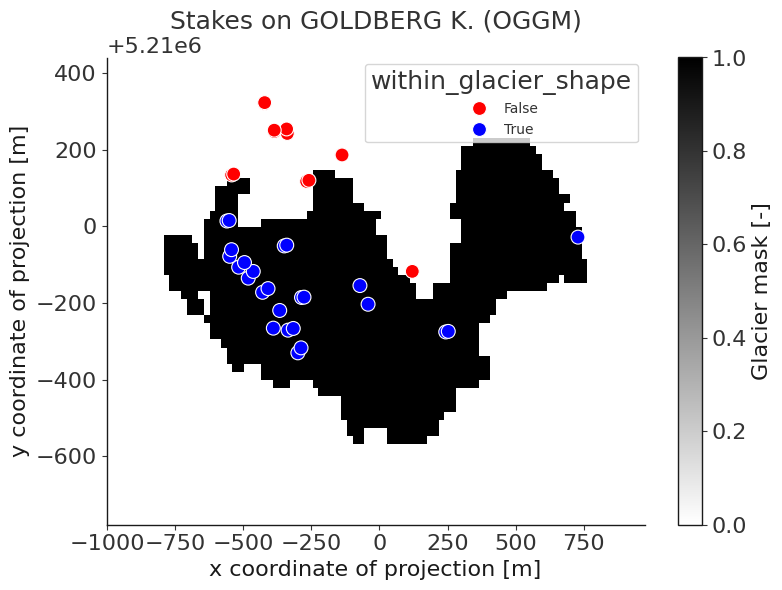

In [12]:
# Example:
glacierName = 'GOLDBERG K.'
# stakes
df_stakes = df_it_at_stakes_dropped_stakes_topo.copy()
df_stakes = df_stakes[(df_stakes['GLACIER'] == glacierName)]
RGIId = df_stakes.RGIId.unique()[0]
print(RGIId)
# open OGGM xr for glacier
# Get oggm data for that RGI grid
ds_oggm = xr.open_dataset(f'{cfg.dataPath + path_OGGM_xrgrids}/{RGIId}.zarr')

# Define the coordinate transformation
transf = pyproj.Transformer.from_proj(
    pyproj.CRS.from_user_input("EPSG:4326"),  # Input CRS (WGS84)
    pyproj.CRS.from_user_input(ds_oggm.pyproj_srs),  # Output CRS from dataset
    always_xy=True)

# Transform all coordinates in the group
lon, lat = df_stakes["POINT_LON"].values, df_stakes["POINT_LAT"].values
x_stake, y_stake = transf.transform(lon, lat)
df_stakes['x'] = x_stake
df_stakes['y'] = y_stake

# plot stakes
plt.figure(figsize=(8, 6))
ds_oggm.glacier_mask.plot(cmap='binary')
sns.scatterplot(df_stakes,
                x='x',
                y='y',
                hue='within_glacier_shape',
                palette=['r', 'b'])
plt.title(f'Stakes on {glacierName} (OGGM)')
plt.tight_layout()

In [13]:
# restrict to within glacier shape
df_it_at_stakes_dropped_stakes_topo = df_it_at_stakes_dropped_stakes_topo[df_it_at_stakes_dropped_stakes_topo['within_glacier_shape']]
df_it_at_stakes_dropped_stakes_topo = df_it_at_stakes_dropped_stakes_topo.drop(columns=['within_glacier_shape'])

print('Number of winter, summer and annual samples:', len(df_it_at_stakes_dropped_stakes_topo))
print('Number of annual samples:',
      len(df_it_at_stakes_dropped_stakes_topo[df_it_at_stakes_dropped_stakes_topo.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_it_at_stakes_dropped_stakes_topo[df_it_at_stakes_dropped_stakes_topo.PERIOD == 'winter']))
print('Number of summer samples:',
      len(df_it_at_stakes_dropped_stakes_topo[df_it_at_stakes_dropped_stakes_topo.PERIOD == 'summer']))
# Unique glaciers, sorted
glacier_list = sorted(df_it_at_stakes_dropped_stakes_topo.GLACIER.unique())
print(f"Number of glaciers: {len(glacier_list)}")
print(f"Glaciers: {glacier_list}")

Number of winter, summer and annual samples: 5086
Number of annual samples: 2872
Number of winter samples: 1548
Number of summer samples: 666
Number of glaciers: 24
Glaciers: ['CAMPO SETT.', 'CARESER', 'CARESER CENTRALE', 'CARESER OCCIDENTALE', 'CARESER ORIENTALE', 'CIARDONEY', 'FONTANA BIANCA / WEISSBRUNNF.', 'GOLDBERG K.', 'GRAND ETRET', 'HALLSTAETTER G.', 'HINTEREIS F.', 'JAMTAL F.', 'KESSELWAND F.', 'KLEINFLEISS K.', 'LUNGA (VEDRETTA) / LANGENF.', 'LUPO', 'MALAVALLE (VEDR. DI) / UEBELTALF.', 'OE. WURTEN K.', 'PENDENTE (VEDR.) / HANGENDERF.', 'RIES OCC. (VEDR. DI) / RIESERF. WESTL.', 'SURETTA MERIDIONALE', 'VENEDIGER K.', 'VERNAGT F.', 'ZETTALUNITZ/MULLWITZ K.']


In [14]:
# Check for NaN
display(df_it_at_stakes_dropped_stakes_topo[df_it_at_stakes_dropped_stakes_topo.isna().any(axis=1)])

,POINT_ID,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,GLACIER,PERIOD,RGIId,YEAR,DATA_MODIFICATION,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness


In [15]:
display(df_it_at_stakes_dropped_stakes_topo.head(2))
df_it_at_stakes_dropped_stakes_topo.to_csv(cfg.dataPath + path_PMB_WGMS_csv + 'IT_AT_wgms_dataset_all_oggm.csv', index=False)

,POINT_ID,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,GLACIER,PERIOD,RGIId,YEAR,DATA_MODIFICATION,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness
0,GOLDBERG K._2020_43346_AT,47.041127,12.965073,2700.0,20190920,20200922,0.276,GOLDBERG K.,annual,RGI60-11.00289,2020,,48.343734,8.445758,2697.0,-1.065098,48.199932
1,GOLDBERG K._2020_43383_AT,47.043262,12.979787,2410.0,20190920,20200922,-1.278,GOLDBERG K.,annual,RGI60-11.00289,2020,,349.177712,16.786407,2421.0,-1.196566,12.570357
